In [ ]:
pip install qiskit

In [ ]:
pip install qiskit-aer-gpu-cu11

issues: 
- initial state by set_statevector instead of .run
- ideal_psi previous step
- transpile leading to small erros 0.02
- n=10/12, k=3
- ||psi_1-psi_2|| is the lower bound
- entropy, density_matrix and sub-system
- python no warning
- make wheel

In [1]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Statevector
from qiskit.quantum_info import DensityMatrix, Statevector, SparsePauliOp, Operator, partial_trace, entropy

from spin import *
from trotter import *
import time

In [2]:
simulator_gpu = AerSimulator(method='statevector', device='CPU')
print(simulator_gpu.available_devices())
print(simulator_gpu.available_methods())

('CPU',)
('automatic', 'statevector', 'density_matrix', 'stabilizer', 'matrix_product_state', 'extended_stabilizer', 'unitary', 'superop')


In [125]:
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.synthesis import LieTrotter
import numpy as np

n = 10 

QIMF = Nearest_Neighbour_1d(n, hx=0.8090, hy=0.9045, Jx=1, pbc=False)

H = QIMF.ham_xyz
print(H)

init = Statevector.from_label("10"*int(n/2))
# init = Statevector.from_label("101010101010")
t = 20
r = 100
m = 10
dt = (t / r)
dt2 = (t / (r*m))

print(dt, dt2)

# trotter_step_first_order = PauliEvolutionGate(H, time=dt, synthesis=LieTrotter())
xx_even = SparsePauliOp.from_sparse_list([*QIMF.xx_tuples[::2]], num_qubits=n).simplify()
xx_odd = SparsePauliOp.from_sparse_list([*QIMF.xx_tuples[1::2]], num_qubits=n).simplify()
x_terms = SparsePauliOp.from_sparse_list([*QIMF.x_tuples], num_qubits=n).simplify()
H_list = [x_terms, QIMF.y_terms, xx_even, xx_odd] # [xx_even, x_terms, qimf.y_terms,xx_odd]
print('Hamiltonian: \n', QIMF.ham)

pf1_xx_e = PauliEvolutionGate(xx_even, dt, synthesis=LieTrotter())
pf1_xx_o = PauliEvolutionGate(xx_odd, dt, synthesis=LieTrotter())
pf1_x = PauliEvolutionGate(x_terms, dt, synthesis=LieTrotter())
pf1_y = PauliEvolutionGate(QIMF.y_terms, dt, synthesis=LieTrotter())

pf1_xx_e_m = PauliEvolutionGate(xx_even, dt/(2*m), synthesis=LieTrotter())
pf1_xx_o_m = PauliEvolutionGate(xx_odd, dt/(2*m), synthesis=LieTrotter())
pf1_x_m = PauliEvolutionGate(x_terms, dt/(2*m), synthesis=LieTrotter())
pf1_y_m = PauliEvolutionGate(QIMF.y_terms, dt/(2*m), synthesis=LieTrotter())

[SparsePauliOp(['IIIIIIIIXX', 'IIIIIIIXXI', 'IIIIIIXXII', 'IIIIIXXIII', 'IIIIXXIIII', 'IIIXXIIIII', 'IIXXIIIIII', 'IXXIIIIIII', 'XXIIIIIIII', 'IIIIIIIIIX', 'IIIIIIIIXI', 'IIIIIIIXII', 'IIIIIIXIII', 'IIIIIXIIII', 'IIIIXIIIII', 'IIIXIIIIII', 'IIXIIIIIII', 'IXIIIIIIII', 'XIIIIIIIII'],
              coeffs=[1.   +0.j, 1.   +0.j, 1.   +0.j, 1.   +0.j, 1.   +0.j, 1.   +0.j,
 1.   +0.j, 1.   +0.j, 1.   +0.j, 0.809+0.j, 0.809+0.j, 0.809+0.j,
 0.809+0.j, 0.809+0.j, 0.809+0.j, 0.809+0.j, 0.809+0.j, 0.809+0.j,
 0.809+0.j]), SparsePauliOp(['IIIIIIIIIY', 'IIIIIIIIYI', 'IIIIIIIYII', 'IIIIIIYIII', 'IIIIIYIIII', 'IIIIYIIIII', 'IIIYIIIIII', 'IIYIIIIIII', 'IYIIIIIIII', 'YIIIIIIIII'],
              coeffs=[0.9045+0.j, 0.9045+0.j, 0.9045+0.j, 0.9045+0.j, 0.9045+0.j, 0.9045+0.j,
 0.9045+0.j, 0.9045+0.j, 0.9045+0.j, 0.9045+0.j])]
0.2 0.02
Hamiltonian: 
 SparsePauliOp(['IIIIIIIIXX', 'IIIIIIIXXI', 'IIIIIIXXII', 'IIIIIXXIII', 'IIIIXXIIII', 'IIIXXIIIII', 'IIXXIIIIII', 'IXXIIIIIII', 'XXIIIIIIII', 'IIIIIIIIIX', '

In [126]:
from qiskit.synthesis import SuzukiTrotter

start_time = time.time()
data, data2 = [], []
ideal_psi = init
total_steps = r*m - 1

for s in range(1, r+1):
  # circ_pf2 = circuit.copy()
  circ_pf1 = QuantumCircuit(n)
  circ_pf1.set_statevector(ideal_psi)
  circ_pf1.append(pf1_y, range(n))
  circ_pf1.append(pf1_x, range(n))
  circ_pf1.append(pf1_xx_e, range(n))
  circ_pf1.append(pf1_xx_o, range(n))
  # circ_pf1.append(trotter_step_first_order, range(n))
  circ_pf1 = circ_pf1.decompose(reps=1)
  circ_pf1.save_statevector(label=f"sv_{s}")
  # circ2 = qc.copy()
  # res0 = simulator_gpu.run(transpile(circ_pf1, optimization_level=0)).result()
  res = simulator_gpu.run(circ_pf1).result()
  ## check infidelity between transpiled and non-transpiled state
  # print("check transpile:", np.vdot(res0.data(0)[f"sv_{s}"], res.data(0)[f"sv_{s}"])**2)
  # print("check transpile:", np.allclose(res0.data(0)[f"sv_{s}"], res.data(0)[f"sv_{s}"]))
  psi = res.data(0)[f"sv_{s}"]
  data.append(psi)

  for ss in range (1, m+1):
    # print("step:", ss)
    circ_pf2 = QuantumCircuit(n)
    circ_pf2.set_statevector(ideal_psi)
    circ_pf2.append(pf1_y_m, range(n))
    circ_pf2.append(pf1_x_m, range(n))
    circ_pf2.append(pf1_xx_e_m, range(n))
    circ_pf2.append(pf1_xx_o_m, range(n))
    circ_pf2.append(pf1_xx_o_m, range(n))
    circ_pf2.append(pf1_xx_e_m, range(n))
    circ_pf2.append(pf1_x_m, range(n))
    circ_pf2.append(pf1_y_m, range(n))
    # circ_pf2.append(pf1_y_m, range(n))
    # circ_pf2.append(pf1_x_m, range(n))
    # circ_pf2.append(pf1_xx_e_m, range(n))
    # circ_pf2.append(pf1_xx_o_m, range(n))
    # circ_pf2.append(trotter_step_second_order, range(n))
    circ_pf2 = circ_pf2.decompose(reps=1)
    circ_pf2.save_statevector(label=f"temp_{total_steps}")

    res2 = simulator_gpu.run(circ_pf2).result()
    temp = res2.data(0)[f"temp_{total_steps}"]
    ideal_psi = temp
    # print(f"temp_{ss}")
    total_steps -= 1

  # ideal_psi = res2.data(0)[f"temp_{total_steps + 1}"]
  data2.append(ideal_psi)


  print('diff =', np.linalg.norm(ideal_psi - psi))

  print("pf1 step:", s)

better_states = data2
states = data

total_time = time.time() - start_time
print("total time", total_time)

diff = 0.2290543222686691
pf1 step: 1
diff = 0.21884465762584718
pf1 step: 2
diff = 0.21719667137564297
pf1 step: 3
diff = 0.24783838932623603
pf1 step: 4
diff = 0.18286769940449957
pf1 step: 5
diff = 0.18098115197300765
pf1 step: 6
diff = 0.15729013886595608
pf1 step: 7
diff = 0.1477284275876113
pf1 step: 8
diff = 0.16637037632551305
pf1 step: 9
diff = 0.1699168660442973
pf1 step: 10
diff = 0.18677405811485934
pf1 step: 11
diff = 0.19103457479443844
pf1 step: 12
diff = 0.1852501612828869
pf1 step: 13
diff = 0.18022503925688127
pf1 step: 14
diff = 0.18605989846580875
pf1 step: 15
diff = 0.18145908560310214
pf1 step: 16
diff = 0.17769837420598852
pf1 step: 17
diff = 0.17425853584980916
pf1 step: 18
diff = 0.16926091771707022
pf1 step: 19
diff = 0.16782100172038295
pf1 step: 20
diff = 0.17433385634654067
pf1 step: 21
diff = 0.1731792129846866
pf1 step: 22
diff = 0.174477847436254
pf1 step: 23
diff = 0.1843077187229931
pf1 step: 24
diff = 0.17772907021068826
pf1 step: 25
diff = 0.17225892

In [127]:
entropy_list = []
entropy_list2 = []

for s in range(1, r+1):
    rdm1 = partial_trace(states[s-1], list(range(1, n)))
    rdm2 = partial_trace(states[s-1], list(range(2, n)))
    rdm3 = partial_trace(states[s-1], list(range(3, n)))
    rdm4 = partial_trace(states[s-1], list(range(4, n)))
    temp_entropy = [entropy(rdm1), entropy(rdm2), entropy(rdm3), entropy(rdm4)]
    print(s, temp_entropy)

    rdm12 = partial_trace(better_states[s-1], list(range(1, n)))
    rdm22 = partial_trace(better_states[s-1], list(range(2, n)))
    rdm32 = partial_trace(better_states[s-1], list(range(3, n)))
    rdm42 = partial_trace(better_states[s-1], list(range(4, n)))
    temp_entropy2 = [entropy(rdm12), entropy(rdm22), entropy(rdm32), entropy(rdm42)]
    print(temp_entropy2)

    entropy_list.append(temp_entropy)
    entropy_list2.append(temp_entropy2)

1 [0.19389611287757852, 0.1938961128775804, 0.193896112877586, 0.19389611287758907]
[0.2243080525603832, 0.22441395332530778, 0.22441376341616476, 0.2244137632884761]
2 [0.4195760313870445, 0.42167404426990807, 0.42166215592122913, 0.4216621192089185]
[0.48694365430504827, 0.48823522468947617, 0.4882078214319073, 0.48820759018455767]
3 [0.5508358332409347, 0.5535954922363499, 0.5534799654659108, 0.5534721798961254]
[0.5904923385456016, 0.592606619039843, 0.5924369125988197, 0.592426913834809]
4 [0.5714887883591551, 0.628341405819415, 0.6288662588437324, 0.6287633478956874]
[0.5707944736195105, 0.6084405500072827, 0.608728362932739, 0.6086382900958952]
5 [0.5217567777173593, 0.7605573954190248, 0.7609167083714473, 0.7605277128834146]
[0.5152623208855805, 0.7065536335242213, 0.7084816779867753, 0.7081522748458468]
6 [0.521520772333722, 0.9480871522956642, 0.9556791400423819, 0.9550835532712338]
[0.5171498276945304, 0.9115183757140815, 0.920009640078915, 0.9193079906147141]
7 [0.601670248

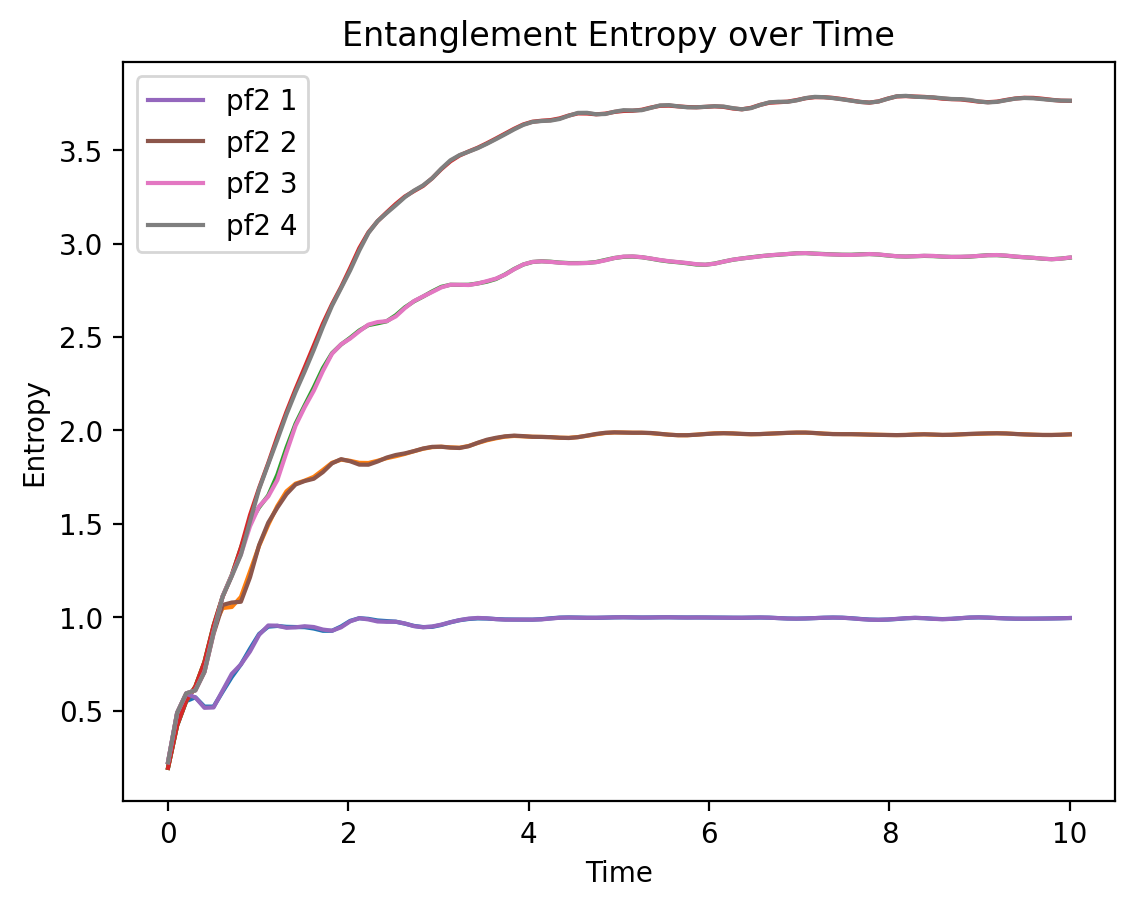

In [128]:
import matplotlib.pyplot as plt
import numpy as np

dt = 0.1
steps = len(entropy_list)
times = np.linspace(0, 10, r)

# Extract the first element of each sublist in entropy_list
entropy_values_1 = [entropy[0] for entropy in entropy_list]
entropy_values_2 = [entropy[1] for entropy in entropy_list]
entropy_values_3 = [entropy[2] for entropy in entropy_list]
entropy_values_4 = [entropy[3] for entropy in entropy_list]


# Extract the first element of each sublist in entropy_list2
entropy_values_12 = [entropy[0] for entropy in entropy_list2]
entropy_values_22 = [entropy[1] for entropy in entropy_list2]
entropy_values_32 = [entropy[2] for entropy in entropy_list2]
entropy_values_42 = [entropy[3] for entropy in entropy_list2]

# Create the plot
plt.plot(times, entropy_values_1)
plt.plot(times, entropy_values_2)
plt.plot(times, entropy_values_3)
plt.plot(times, entropy_values_4)

plt.plot(times, entropy_values_12, label='pf2 1')
plt.plot(times, entropy_values_22, label='pf2 2')
plt.plot(times, entropy_values_32, label='pf2 3')
plt.plot(times, entropy_values_42, label='pf2 4')

plt.xlabel("Time")
plt.ylabel("Entropy")
plt.title("Entanglement Entropy over Time")
plt.legend()
plt.show()

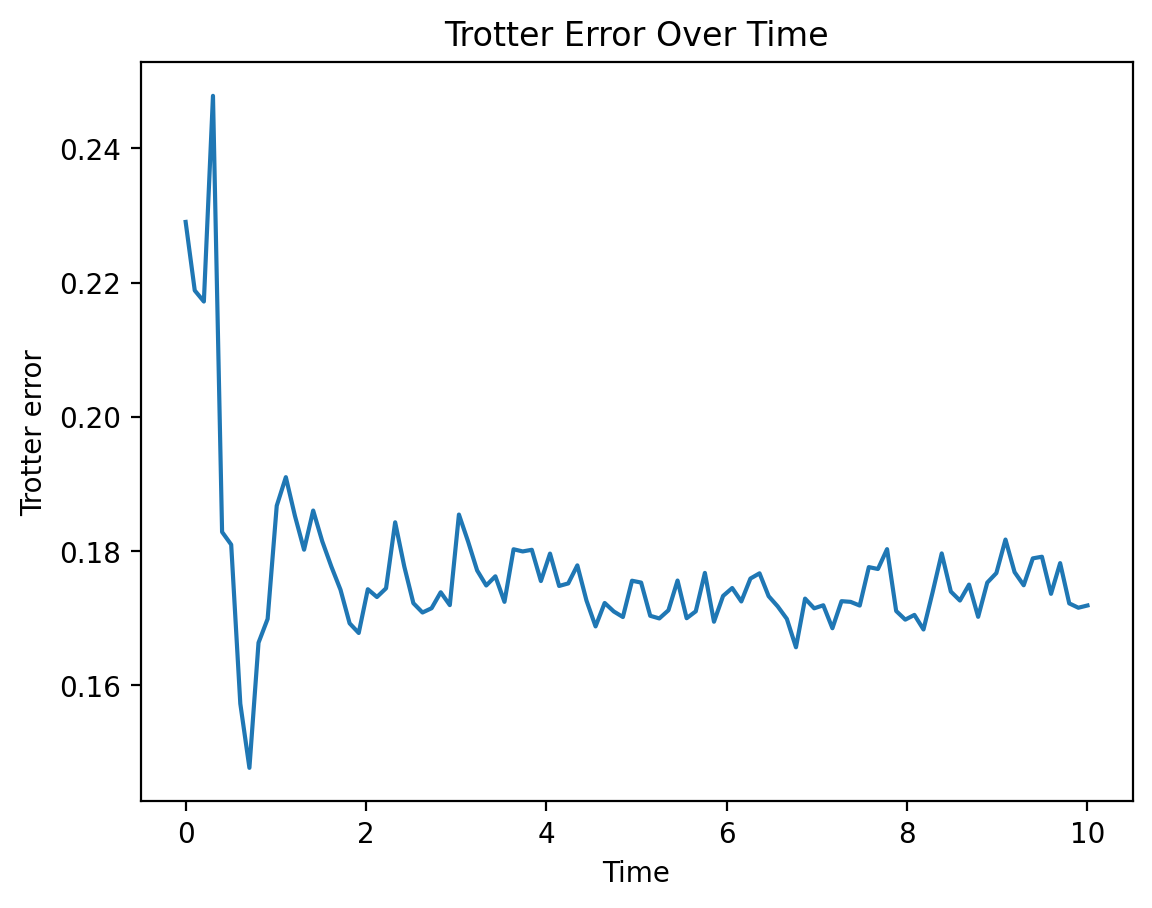

In [129]:
trotter_error = []
for s in range(0, r):
  tro = np.linalg.norm(better_states[s] - states[s])
  # tro = 1 - np.abs(np.vdot(better_states[s], states[s]))**2
  # print(tro)
  trotter_error.append(tro)

times = np.linspace(0, 10, r)
plt.plot(times, trotter_error)
plt.xlabel("Time")
plt.ylabel("Trotter error")
plt.title("Trotter Error Over Time")
plt.show()